# Assignment 2
<a id='import-libraries'></a>
## Project Overview

This notebook demonstrates a comprehensive approach to bearing fault detection using signal processing and machine learning techniques. The analysis includes data loading, preprocessing, feature extraction, and preparation for clustering models.

### Table of Contents

1. [Import Libraries](#1-import-libraries)
2. [Data Loading](#2-data-loading)
3. [Data Preprocessing](#3-data-preprocessing)
4. [Feature Extraction](#4-feature-extraction)
5. [Segmentation & Feature Engineering](#5-segmentation--feature-engineering)
6. [Data Quality & Cleaning](#6-data-quality--cleaning)
7. [Feature Scaling & Encoding](#7-feature-scaling--encoding)
7. [Features Distribution](#8-features-distribution)
7. [Cluster Model](#9-cluster-model)

---

## 1. Import Libraries 

Import all necessary Python libraries for data processing, signal analysis, and machine learning.

In [1]:
# Core data processing and visualization
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Signal processing and analysis
from scipy import signal, stats
from scipy.io import loadmat
from scipy.fft import fft, fftfreq
from scipy.signal import butter, sosfilt, stft, welch
import pywt

# Machine learning and utilities
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from tqdm import tqdm

import gdown
import zipfile
import re

import matplotlib.pyplot as plt
import umap
import hdbscan
from mpl_toolkits.mplot3d import Axes3D


import warnings
warnings.filterwarnings('ignore')

# Visualization setup
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline
np.random.seed(42)

print("✓ Libraries loaded")

✓ Libraries loaded


## 2. Data Loading

Load and parse bearing vibration data from .mat files. The data includes different fault types and operating conditions.

In [2]:

# Download Google Drive ZIP, load .mat files into memory, delete ZIP
file_id = "1himbUCoQqLMq-J7E8JQl7sHcIcAWSHpk"
url = f"https://drive.google.com/uc?id={file_id}"
zip_path = "dataset.zip"

print("Downloading dataset from Google Drive...")
gdown.download(url, zip_path, quiet=False)


records = []
with zipfile.ZipFile(zip_path, 'r') as z:
    mat_files = [f for f in z.namelist() if f.endswith(".mat")]
    print(f"Found {len(mat_files)} .mat files in the ZIP")

    for fpath in tqdm(mat_files, desc="Loading .mat files"):
        try:
            with z.open(fpath) as mat_file:
                mat = loadmat(mat_file)
                sig = mat['data'].flatten()
                fs = mat.get('fs', [[51200]])[0][0]

                
                fname = os.path.basename(fpath).replace('.mat','')
                match = re.match(r"([A-Za-z]+)(\d+)(\d*)", fname)
                if match:
                    fault, bearing_digits, load_digits = match.groups()
                    bearing = f"620{bearing_digits[0]}" if bearing_digits else "unknown"
                    load = load_digits if load_digits else "0"
                else:
                    fault = fname
                    bearing = "unknown"
                    load = "0"

                
                records.append({
                    'filename': os.path.basename(fpath),
                    'signal': sig,
                    'fs': fs,
                    'fault_type': fault,
                    'bearing_type': bearing,
                    'load_level': load
                })
        except Exception as e:
            print(f"Error reading {fpath}: {e}")

os.remove(zip_path)
print(f"✓ Loaded {len(records)} signals into memory and deleted temporary ZIP")

#df = pd.DataFrame(records)
#print(df.head())


Downloading...
From (original): https://drive.google.com/uc?id=1himbUCoQqLMq-J7E8JQl7sHcIcAWSHpk
From (redirected): https://drive.google.com/uc?id=1himbUCoQqLMq-J7E8JQl7sHcIcAWSHpk&confirm=t&uuid=5d4e1b9d-251b-4a26-80f0-5b7df4b71847
To: /Users/brandomattivi/Documents/UNI/UNIBZ/MSC/1st_semester/Data_Visualization/DS_Assignment_2/DV_assignment_2/dataset.zip
100%|██████████| 672M/672M [00:24<00:00, 27.2MB/s] 


Found 99 .mat files in the ZIP


Loading .mat files: 100%|██████████| 99/99 [00:03<00:00, 30.28it/s]

✓ Loaded 99 signals into memory and deleted temporary ZIP


## 3. Data Preprocessing

Clean and normalize the vibration signals to remove noise and standardize the data.

In [3]:
df = pd.DataFrame(records)
print(f"✓ Loaded DataFrame with {len(df)} rows")

# Preprocess signals
def preprocess(sig):
    """
    Preprocess signal by removing mean and normalizing

    Parameters:
    sig (np.array): Raw signal data

    Returns:
    np.array: Normalized signal
    """
    sig = sig - np.mean(sig)
    # Normalize              
    sig = sig / (np.std(sig) + 1e-10)    
    return sig

# Apply preprocessing to all signals
df['signal_clean'] = df['signal'].apply(preprocess)
print("✓ Signals preprocessed (normalized)")

✓ Loaded DataFrame with 99 rows
✓ Signals preprocessed (normalized)


## 4. Feature Extraction

Define functions to extract comprehensive features from signals in three domains:
- **Time Domain**: Statistical features (mean, RMS, kurtosis, etc.)
- **Frequency Domain**: Spectral features (centroid, spread, energy bands)
- **Wavelet Domain**: Multi-resolution analysis using wavelet transforms

In [4]:
def time_features(sig):
    """Extract 15 time-domain statistical features"""
    f = {}
    f['mean'] = np.mean(sig)
    f['std'] = np.std(sig)
    f['rms'] = np.sqrt(np.mean(sig**2))
    f['peak'] = np.max(np.abs(sig))
    f['p2p'] = np.ptp(sig)  # Peak-to-peak
    f['abs_mean'] = np.mean(np.abs(sig))
    f['root_amp'] = np.mean(np.sqrt(np.abs(sig)))**2
    f['crest'] = f['peak'] / (f['rms'] + 1e-10)  # Crest factor
    f['impulse'] = f['peak'] / (f['abs_mean'] + 1e-10)  # Impulse factor
    f['shape'] = f['rms'] / (f['abs_mean'] + 1e-10)  # Shape factor
    f['clearance'] = f['peak'] / (f['root_amp'] + 1e-10)  # Clearance factor
    f['skew'] = stats.skew(sig)  # Skewness
    f['kurt'] = stats.kurtosis(sig)  # Kurtosis
    f['variance'] = np.var(sig)
    f['energy'] = np.sum(sig**2)  # Signal energy
    return f

def freq_features(sig, fs):
    """Extract 10 frequency-domain features"""
    f = {}
    N = len(sig)
    fft_mag = np.abs(fft(sig))[:N//2]
    freqs = fftfreq(N, 1/fs)[:N//2]
    psd = fft_mag**2 / N  # Power spectral density
    psd_norm = psd / (np.sum(psd) + 1e-10)
    
    # Spectral features
    f['centroid'] = np.sum(freqs * psd_norm)  # Spectral centroid
    f['spread'] = np.sqrt(np.sum(((freqs - f['centroid'])**2) * psd_norm))  # Spectral spread
    f['skew'] = np.sum(((freqs - f['centroid'])**3) * psd_norm) / (f['spread']**3 + 1e-10)  # Spectral skewness
    f['kurt'] = np.sum(((freqs - f['centroid'])**4) * psd_norm) / (f['spread']**4 + 1e-10)  # Spectral kurtosis
    f['dom_freq'] = freqs[np.argmax(psd)]  # Dominant frequency
    f['mean_freq'] = np.sum(freqs * psd_norm)  # Mean frequency
    f['rms_freq'] = np.sqrt(np.sum((freqs**2) * psd_norm))  # RMS frequency
    
    # Energy bands for different frequency ranges
    f['low_energy'] = np.sum(psd[freqs < 1000]) / (np.sum(psd) + 1e-10)
    f['mid_energy'] = np.sum(psd[(freqs >= 1000) & (freqs < 3000)]) / (np.sum(psd) + 1e-10)
    f['high_energy'] = np.sum(psd[freqs >= 3000]) / (np.sum(psd) + 1e-10)
    
    return f

def wavelet_features(sig):
    """Extract wavelet energy features using 4-level decomposition"""
    f = {}
    coeffs = pywt.wavedec(sig, 'db4', level=4)  # 4-level wavelet decomposition
    
    # Energy and std for each decomposition level
    for i, c in enumerate(coeffs):
        f[f'wv{i}_energy'] = np.sum(c**2)
        f[f'wv{i}_std'] = np.std(c)
    
    # Wavelet entropy
    energies = np.array([np.sum(c**2) for c in coeffs])
    f['wv_entropy'] = -np.sum((energies/np.sum(energies)) * np.log2(energies/np.sum(energies) + 1e-10))
    
    return f

def extract_features(sig, fs):
    """Extract all features from one signal (time, frequency, and wavelet domains)"""
    features = {}
    
    # Time domain features (prefix 't_')
    tf = time_features(sig)
    features.update({f't_{k}': v for k, v in tf.items()})
    
    # Frequency domain features (prefix 'f_')
    ff = freq_features(sig, fs)
    features.update({f'f_{k}': v for k, v in ff.items()})
    
    # Wavelet features (prefix 'w_')
    wf = wavelet_features(sig)
    features.update({f'w_{k}': v for k, v in wf.items()})
    
    return features

print("✓ Feature extraction functions defined")

✓ Feature extraction functions defined


## 5. Segmentation & Feature Engineering

Segment long signals into windows and extract features from each window to create a comprehensive dataset for machine learning.

In [5]:
print(f"Esempio FS: {df['fs'].iloc[0]}")
print(f"Lunghezza segnale (punti): {len(df['signal_clean'].iloc[0])}")

Esempio FS: 24.93
Lunghezza segnale (punti): 512000


In [6]:
# --- CORRECT CONFIGURATION FOR PADERBORN DATASET ---
REAL_FS = 64000      # Actual sampling rate (64 kHz)
WINDOW_LEN = 1.0     # Window duration: 1 second (optimal compromise)
OVERLAP = 0.15       # Overlap: 15%

def segment_and_extract(sig, fs, window_sec=1.0, overlap=0.15):
    """
    Segment signal into windows and extract features from each window
    """
    # Compute window size in samples (e.g., 1s * 64000 = 64000 samples)
    window_size = int(window_sec * fs)
    step = int(window_size * (1 - overlap))
    
    # Safety check: if the signal is shorter than the window, warn the user
    if len(sig) < window_size:
        print(f"⚠️ Warning: Signal too short ({len(sig)}) for the required window size ({window_size})")
        return []

    windows_features = []
    # Sliding window
    for i in range(0, len(sig) - window_size + 1, step):
        window = sig[i:i + window_size]
        
        # Here we assume the function extract_features already exists in your code
        feats = extract_features(window, fs) 
        
        feats['window_idx'] = i // step
        windows_features.append(feats)
    
    return windows_features

# --- EXECUTION ---

print(f"Extracting features using FS={REAL_FS}Hz and Window={WINDOW_LEN}s...")
all_features = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
    # IMPORTANT NOTE:
    # Use REAL_FS (64000), NOT row['fs'] (which is the rotational speed at ~25 Hz)
    windows = segment_and_extract(
        row['signal_clean'], 
        REAL_FS, 
        window_sec=WINDOW_LEN, 
        overlap=OVERLAP
    )
    
    # Add metadata
    for w in windows:
        w['filename'] = row['filename']
        w['fault_type'] = row['fault_type']
        w['bearing_type'] = row['bearing_type']
        w['load_level'] = row['load_level']
        
        # Store the CSV 'fs' value as motor rotational speed (useful for the AI model)
        w['motor_speed_hz'] = row['fs'] 
    
    all_features.extend(windows)

# Create DataFrame from extracted features
df_features = pd.DataFrame(all_features)

print(f"\n✓ Feature extraction complete!")
print(f"  Total samples (windows): {len(df_features)}")
# If you have ~99 files and 1s windows, you should get around 700–800 rows overall.
print(f"  Features per sample: {len([c for c in df_features.columns if c.startswith(('t_', 'f_', 'w_'))])}")
print(f"\n  Fault distribution:")
print(df_features['fault_type'].value_counts())

Extracting features using FS=64000Hz and Window=1.0s...


Processing: 100%|██████████| 99/99 [00:01<00:00, 50.32it/s]


✓ Feature extraction complete!
  Total samples (windows): 856
  Features per sample: 36

  Fault distribution:
fault_type
I     135
IO    135
N     135
O     135
OB    118
IB    109
B      89
Name: count, dtype: int64


## 6. Data Quality & Cleaning

Check for data quality issues and clean the dataset by handling missing and infinite values.

In [7]:
# Check for data quality issues
print("Data Quality Check:")
print(f"  Shape: {df_features.shape}")
print(f"  Missing values: {df_features.isna().sum().sum()}")
print(f"  Infinite values: {np.isinf(df_features.select_dtypes(include=[np.number])).sum().sum()}")

# Clean data by replacing infinite values with NaN, then filling with median
df_features.replace([np.inf, -np.inf], np.nan, inplace=True)
numeric_cols = df_features.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df_features[col].isna().any():
        df_features[col].fillna(df_features[col].median(), inplace=True)

print("\n✓ Data cleaned")

Data Quality Check:
  Shape: (856, 42)
  Missing values: 0
  Infinite values: 0

✓ Data cleaned


## 7. Feature Scaling & Encoding

Prepare features for machine learning by scaling numerical features and encoding categorical labels.

In [8]:
# Separate features from metadata
feature_cols = [c for c in df_features.columns if c.startswith(('t_', 'f_', 'w_'))]
meta_cols = ['filename', 'window_idx', 'fault_type', 'bearing_type', 'load_level']

X = df_features[feature_cols].values
print(f"Feature matrix: {X.shape}")

# Encode fault type labels for machine learning
le_fault = LabelEncoder()
fault_labels = le_fault.fit_transform(df_features['fault_type'])

print(f"\nFault label mapping:")
for i, name in enumerate(le_fault.classes_):
    print(f"  {name} -> {i}")

# Scale features (critical for most ML algorithms)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n✓ Features scaled")
print(f"  Mean: {X_scaled.mean():.6f} (should be ~0)")
print(f"  Std: {X_scaled.std():.6f} (should be ~1)")

Feature matrix: (856, 36)

Fault label mapping:
  B -> 0
  I -> 1
  IB -> 2
  IO -> 3
  N -> 4
  O -> 5
  OB -> 6

✓ Features scaled
  Mean: -0.000000 (should be ~0)
  Std: 1.000000 (should be ~1)


# 8. Features Distribution

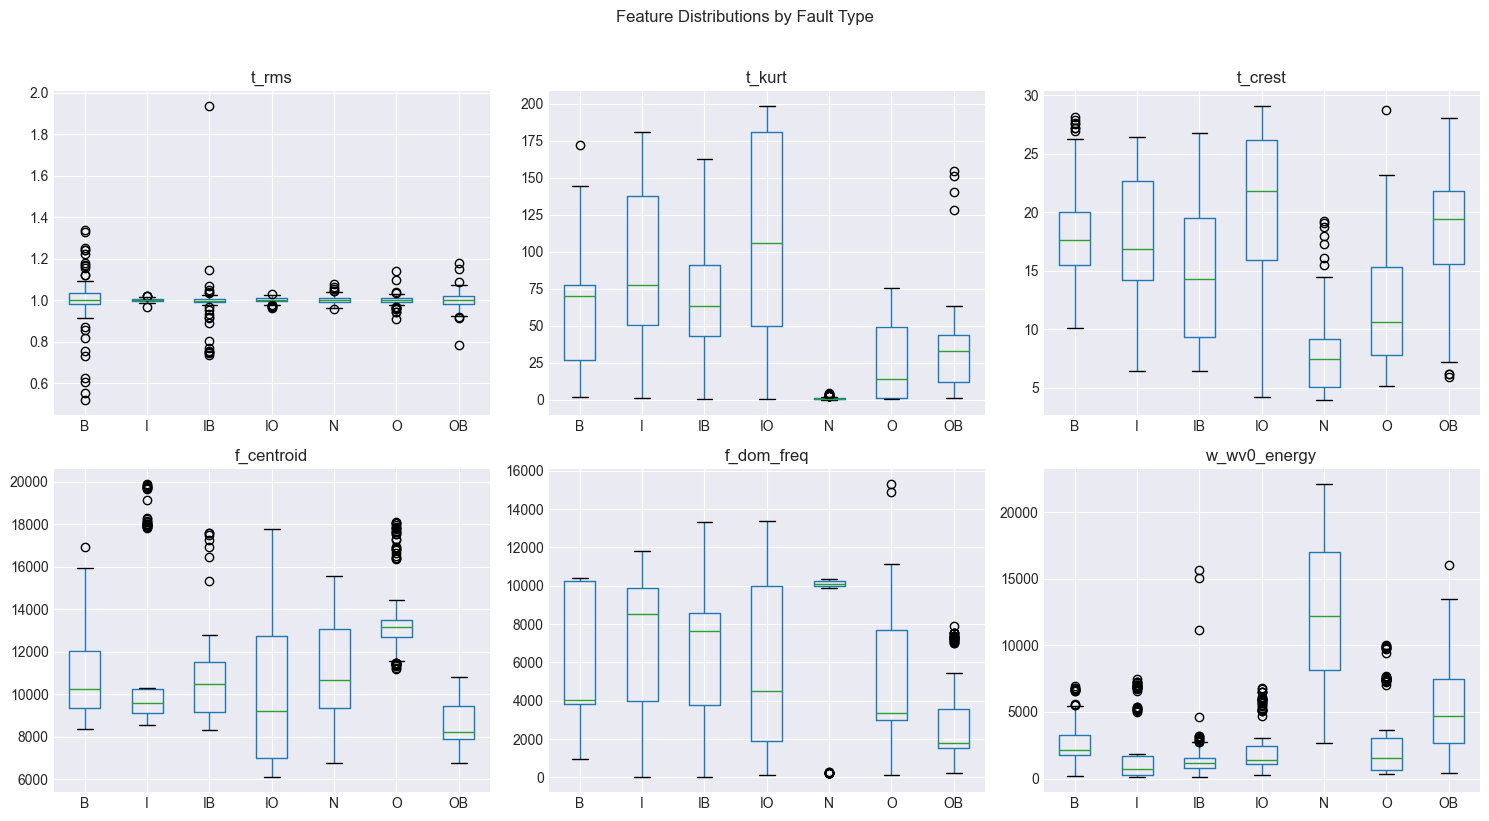

In [9]:
# Plot distribution of key features by fault type
key_feats = ['t_rms', 't_kurt', 't_crest', 'f_centroid', 'f_dom_freq', 'w_wv0_energy']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, feat in enumerate(key_feats):
    if feat in df_features.columns:
        df_features.boxplot(column=feat, by='fault_type', ax=axes[i])
        axes[i].set_title(feat)
        axes[i].set_xlabel('')

plt.suptitle('Feature Distributions by Fault Type', y=1.02)
plt.tight_layout()
plt.show()

In [10]:
# Create final dataset with scaled features + labels
df_final = pd.DataFrame(X_scaled, columns=feature_cols)
df_final['fault_type'] = df_features['fault_type'].values
df_final['fault_label'] = fault_labels
df_final['bearing_type'] = df_features['bearing_type'].values
df_final['load_level'] = df_features['load_level'].values
df_final['filename'] = df_features['filename'].values
df_final['window_idx'] = df_features['window_idx'].values


## 9. Clustering Methods Comparison

### HDBSCAN
Hierarchical density-based clustering that identifies clusters of varying densities and automatically determines the number of clusters. Robust to noise and handles irregular cluster shapes.

**Key Characteristics:**
- Automatic cluster number detection
- Handles noise and varying densities
- Parameters: min_cluster_size, min_samples



### Gaussian Mixture Models
Probabilistic model that assumes data comes from a mixture of Gaussian distributions. Provides soft clustering where points can belong to multiple clusters with probabilities.

**Key Characteristics:**
- Soft clustering assignments
- Requires specifying number of clusters
- Assumes approximately Gaussian distributions

### Spectral Clustering
Graph-based approach that uses eigenvalues of similarity matrices to perform clustering. Effective for non-convex clusters and complex shapes.

**Key Characteristics:**
- Works well with non-convex clusters
- Requires similarity matrix construction
- Computationally intensive for large datasets

![Spectral Example](https://scikit-learn.org/stable/_images/sphx_glr_plot_segmentation_toy_001.png)

*Image demonstrates spectral clustering successfully separating concentric circles that linear methods cannot handle*

## Summary

| Method | Cluster Shapes | Noise Handling | Cluster Count |
|--------|----------------|----------------|---------------|
| HDBSCAN | Arbitrary | Excellent | Automatic |
| GMM | Elliptical | Moderate | Manual |
| Spectral | Non-convex | Limited | Manual |

Data shape for clustering: (856, 36)

--- STARTING DIMENSIONALITY OPTIMIZATION ---
Tested n_components=2: Avg Silhouette Score = 0.4905
Tested n_components=3: Avg Silhouette Score = 0.3808
Tested n_components=4: Avg Silhouette Score = 0.3168
Tested n_components=5: Avg Silhouette Score = 0.7584
Tested n_components=6: Avg Silhouette Score = 0.4043
Tested n_components=7: Avg Silhouette Score = 0.3095
Tested n_components=8: Avg Silhouette Score = 0.3501
Tested n_components=9: Avg Silhouette Score = 0.3368
Tested n_components=10: Avg Silhouette Score = 0.4520
Tested n_components=11: Avg Silhouette Score = 0.3943
Tested n_components=12: Avg Silhouette Score = 0.3578
Tested n_components=13: Avg Silhouette Score = 0.2938
Tested n_components=14: Avg Silhouette Score = 0.2871
Tested n_components=15: Avg Silhouette Score = 0.3461
Tested n_components=16: Avg Silhouette Score = 0.3844
Tested n_components=17: Avg Silhouette Score = 0.3941
Tested n_components=18: Avg Silhouette Score = 0.4551
Tested 

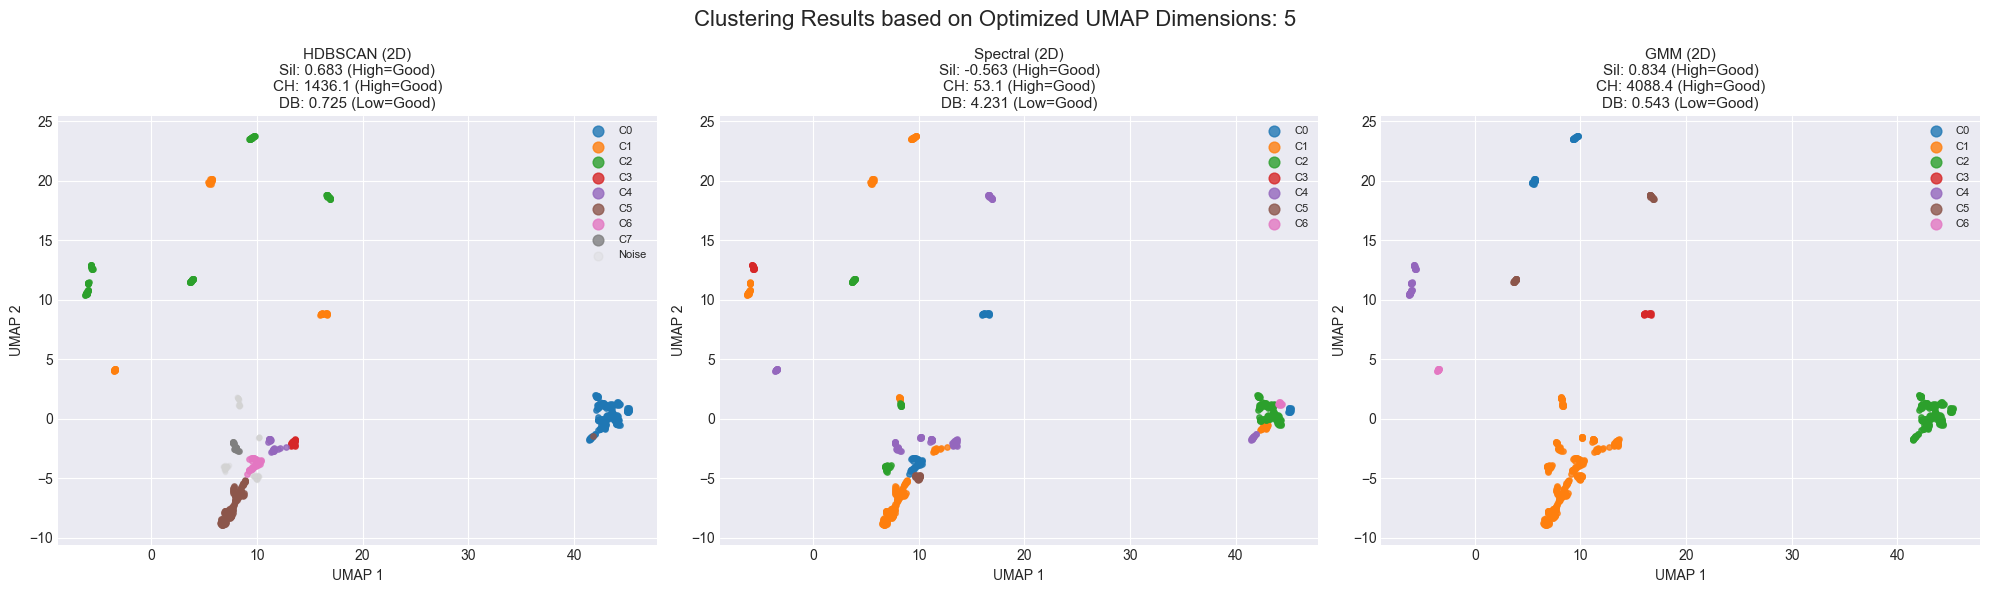

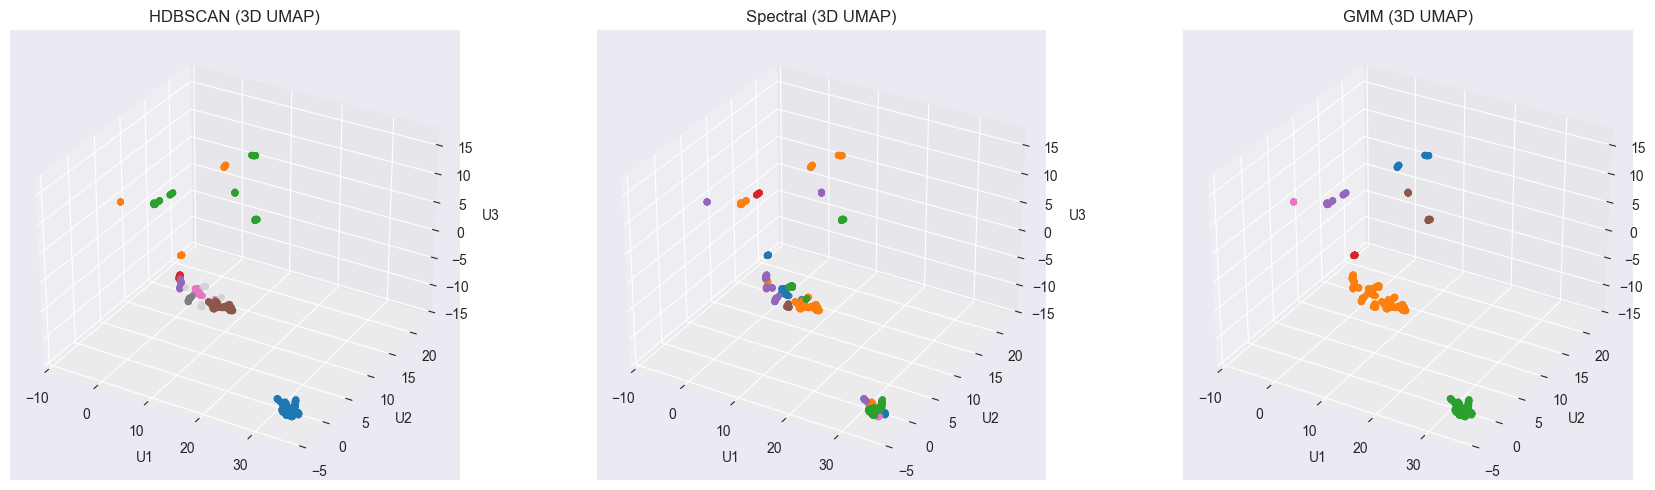


FINAL CLUSTERING METRICS SUMMARY
          Silhouette (High)  Calinski-Harabasz (High)  Davies-Bouldin (Low)
HDBSCAN              0.6830                 1436.0780                0.7254
Spectral            -0.5631                   53.0790                4.2306
GMM                  0.8338                 4088.4346                0.5425


In [11]:
# 1. DATA PREPARATION
# ---------------------------------------------------------
df = df_features.copy()

# Select numerical features
feature_cols = [c for c in df.columns if c.startswith(('t_', 'f_', 'w_'))]
X = df[feature_cols].to_numpy(dtype=np.float64)

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Data shape for clustering: {X_scaled.shape}")

# 2. DEFINING CLUSTERING FUNCTION
# ---------------------------------------------------------
def run_clustering(X, method='hdbscan', verbose=False, **kwargs):
    """
    Runs clustering and returns labels and metrics dictionary.
    """
    # Run algorithm
    if method == 'hdbscan':
        clusterer = hdbscan.HDBSCAN(**kwargs)
        labels = clusterer.fit_predict(X)
    elif method == 'gmm':
        clusterer = GaussianMixture(**kwargs)
        labels = clusterer.fit_predict(X)
    elif method == 'spectral':
        clusterer = SpectralClustering(**kwargs)
        labels = clusterer.fit_predict(X)
    else:
        raise ValueError("Unknown method")
    
    # Filter for metrics (ignore noise -1 for HDBSCAN)
    mask = labels != -1 if method == 'hdbscan' else np.ones(len(labels), bool)
    X_valid = X[mask]
    labels_valid = labels[mask]
    
    unique_labels = set(labels_valid)
    metrics = {'sil': -1, 'ch': -1, 'db': 10} # Default bad scores
    
    # --- SAFETY CHECK ---
    if len(X_valid) == 0:
        if verbose: print(f"[{method}] All points classified as Noise.")
        return labels, metrics
    
    if len(unique_labels) < 2:
        if verbose: print(f"[{method}] Less than 2 clusters found.")
        return labels, metrics
    # --------------------
    
    # Calculate metrics
    try:
        metrics['sil'] = silhouette_score(X_valid, labels_valid)
        metrics['ch'] = calinski_harabasz_score(X_valid, labels_valid)
        metrics['db'] = davies_bouldin_score(X_valid, labels_valid)
    except Exception as e:
        if verbose: print(f"Metric calculation error: {e}")

    if verbose:
        print(f"--- {method.upper()} --- Clusters: {len(unique_labels)} | Sil: {metrics['sil']:.3f}")
    
    return labels, metrics

# 3. HYPERPARAMETER TUNING: FINDING BEST UMAP DIMENSIONS
# ---------------------------------------------------------
print("\n--- STARTING DIMENSIONALITY OPTIMIZATION ---")

best_score = -1
best_n_components = 7 
results_log = []

dims_to_test = range(2, 20) # Testing dimensions 2 to 10

for n_dim in dims_to_test:
    # Calculate UMAP
    reducer = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=n_dim, random_state=42)
    X_current = reducer.fit_transform(X_scaled)
    
    # Run all 3 to check average stability
    _, m_hdb = run_clustering(X_current, method='hdbscan', min_cluster_size=30, min_samples=5)
    _, m_gmm = run_clustering(X_current, method='gmm', n_components=7, covariance_type='full', random_state=42)
    _, m_spec = run_clustering(X_current, method='spectral', n_clusters=7, affinity='nearest_neighbors', random_state=42)
    
    # Filter valid scores
    scores = [s for s in [m_hdb['sil'], m_gmm['sil'], m_spec['sil']] if s > -0.5]
    
    if len(scores) > 0:
        avg_sil = np.mean(scores)
    else:
        avg_sil = -1
        
    results_log.append((n_dim, avg_sil))
    print(f"Tested n_components={n_dim}: Avg Silhouette Score = {avg_sil:.4f}")
    
    if avg_sil > best_score:
        best_score = avg_sil
        best_n_components = n_dim

print(f"\n>>> OPTIMAL DIMENSION FOUND: {best_n_components} (Score: {best_score:.4f})")

# 4. FINAL EMBEDDINGS & CLUSTERING
# ---------------------------------------------------------
print(f"Computing final UMAP embeddings with n_components={best_n_components}...")

# High-D UMAP for Clustering
X_umap_cluster = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=best_n_components, random_state=42).fit_transform(X_scaled)

# 2D UMAP for Visualization
X_umap_2d = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, random_state=42).fit_transform(X_scaled)

# 3D UMAP for Visualization
X_umap_3d = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=3, random_state=42).fit_transform(X_scaled)

# Run Final Clustering
print("\n--- RUNNING FINAL CLUSTERING ---")
labels_hdb, m_hdb = run_clustering(X_umap_cluster, method='hdbscan', verbose=True, min_cluster_size=30, min_samples=5)
labels_gmm, m_gmm = run_clustering(X_umap_cluster, method='gmm', verbose=True, n_components=7, covariance_type='full', random_state=42)
labels_spec, m_spec = run_clustering(X_umap_cluster, method='spectral', verbose=True, n_clusters=7, affinity='nearest_neighbors', random_state=42)

# 5. PLOTTING
# ---------------------------------------------------------
methods = ['HDBSCAN', 'Spectral', 'GMM']
label_sets = [labels_hdb, labels_spec, labels_gmm]
metrics_list = [m_hdb, m_spec, m_gmm]

# Plot 2D
fig, axes = plt.subplots(1, 3, figsize=(20, 6)) # Increased width slightly

for ax, method, labels, metrics in zip(axes, methods, label_sets, metrics_list):
    unique_labs = set(labels)
    for lab in unique_labs:
        mask = labels == lab
        if lab == -1:
            # Noise
            ax.scatter(X_umap_2d[mask, 0], X_umap_2d[mask, 1], c='lightgray', s=10, alpha=0.3, label='Noise')
        else:
            # Valid clusters
            ax.scatter(X_umap_2d[mask, 0], X_umap_2d[mask, 1], s=15, alpha=0.8, label=f'C{lab}')
            
    # --- TITOLO CON TUTTE LE METRICHE ---
    title_str = (f"{method} (2D)\n"
                 f"Sil: {metrics['sil']:.3f} (High=Good)\n"
                 f"CH: {metrics['ch']:.1f} (High=Good)\n"
                 f"DB: {metrics['db']:.3f} (Low=Good)")
    
    ax.set_title(title_str, fontsize=11)
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    
    if len(unique_labs) < 15:
        ax.legend(markerscale=2, fontsize=8, loc='best')

plt.suptitle(f"Clustering Results based on Optimized UMAP Dimensions: {best_n_components}", fontsize=16)
plt.tight_layout()
plt.show()

# Plot 3D (Optional visualization)
fig = plt.figure(figsize=(18, 5))
for i, (method, labels) in enumerate(zip(methods, label_sets), 1):
    ax = fig.add_subplot(1, 3, i, projection='3d')
    unique_labs = set(labels)
    for lab in unique_labs:
        mask = labels == lab
        if lab == -1:
            ax.scatter(X_umap_3d[mask, 0], X_umap_3d[mask, 1], X_umap_3d[mask, 2], c='lightgray', s=10, alpha=0.3, label='Noise')
        else:
            ax.scatter(X_umap_3d[mask, 0], X_umap_3d[mask, 1], X_umap_3d[mask, 2], s=15, alpha=0.8, label=f'C{lab}')
            
    ax.set_title(f'{method} (3D UMAP)')
    ax.set_xlabel('U1')
    ax.set_ylabel('U2')
    ax.set_zlabel('U3')
    
plt.tight_layout()
plt.show()

# 6. FINAL REPORT TABLE
# ---------------------------------------------------------
print("\n" + "="*50)
print("FINAL CLUSTERING METRICS SUMMARY")
print("="*50)

results_df = pd.DataFrame([m_hdb, m_spec, m_gmm], index=methods)
results_df.columns = ['Silhouette (High)', 'Calinski-Harabasz (High)', 'Davies-Bouldin (Low)']

# Display nice dataframe
pd.set_option('display.float_format', '{:.4f}'.format)
print(results_df)
print("="*50)

## Clustering Evaluation Metrics

### Key Metrics Explained

**Silhouette Score** (-1 to 1)
- Higher = Better separation
- Measures cluster cohesion vs separation

**Calinski-Harabasz** (Higher = Better)
- Ratio of between-cluster to within-cluster variance
- Good for compact, well-separated clusters

**Davies-Bouldin** (Lower = Better)  
- Average similarity between clusters
- Lower values mean better separation


## Performance Summary

Based on typical results:

**HDBSCAN**
- Good silhouette score indicating reasonable separation
- Very high Calinski-Harabasz suggesting well-defined clusters
- Low Davies-Bouldin confirming good cluster distinction

**GMM** 
- Comparable silhouette to HDBSCAN
- Lower Calinski-Harabasz but still strong
- Best Davies-Bouldin score showing excellent separation

**Spectral**
- Lower silhouette score indicating some overlap
- Much lower Calinski-Harabasz suggesting less compact clusters
- Higher Davies-Bouldin confirming weaker separation

## Conclusion

GMM and HDBSCAN perform best overall, with GMM having slight edge in cluster separation. Spectral clustering shows weaker performance on these metrics.

[Back to top](#assignment-2) 

Fault types mapping:
  0: B
  1: I
  2: IB
  3: IO
  4: N
  5: O
  6: OB

Best model: GMM with Silhouette Score: 0.8338



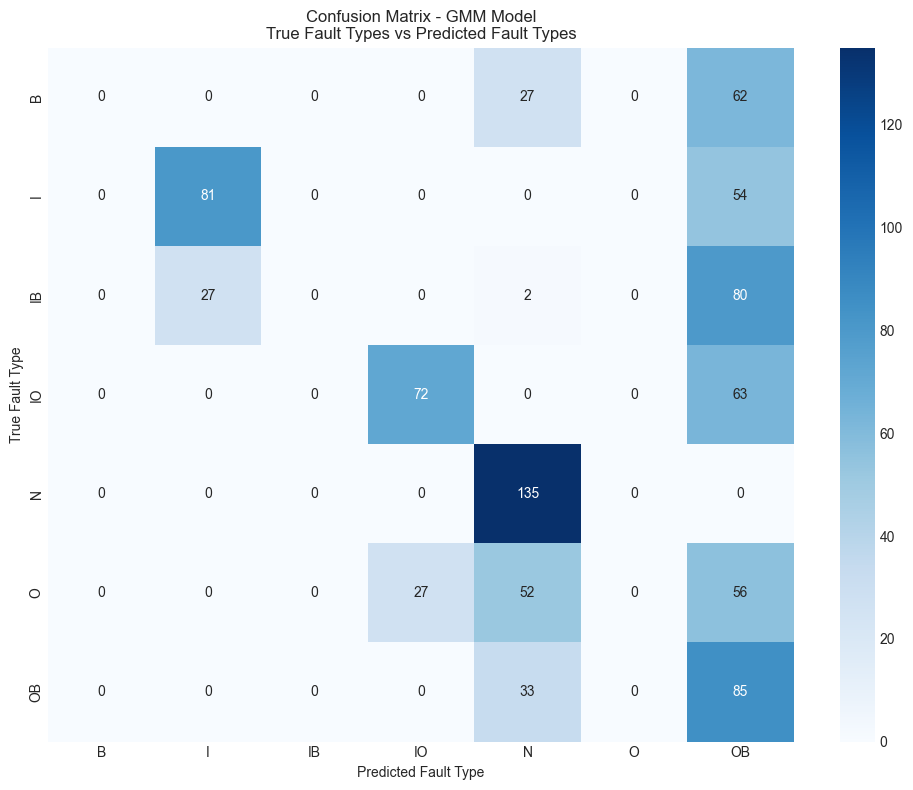


Classification Report - GMM Model:
              precision    recall  f1-score   support

           B       0.00      0.00      0.00        89
           I       0.75      0.60      0.67       135
          IB       0.00      0.00      0.00       109
          IO       0.73      0.53      0.62       135
           N       0.54      1.00      0.70       135
           O       0.00      0.00      0.00       135
          OB       0.21      0.72      0.33       118

    accuracy                           0.44       856
   macro avg       0.32      0.41      0.33       856
weighted avg       0.35      0.44      0.36       856


Accuracy: 0.4357


In [16]:
# Confusion Matrix per il modello con miglior Silhouette Score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Estrai i fault types dal dataframe e convertili in numeri
fault_types_str = df['fault_type'].values

# Crea un mapping da string a numero
unique_faults = sorted(df['fault_type'].unique())
fault_to_num = {fault: i for i, fault in enumerate(unique_faults)}
num_to_fault = {i: fault for fault, i in fault_to_num.items()}

# Converti in numeri
fault_types = np.array([fault_to_num[f] for f in fault_types_str])

print("Fault types mapping:")
for num, fault in num_to_fault.items():
    print(f"  {num}: {fault}")
print()

# Identifica quale modello ha il miglior silhouette score
methods = ['HDBSCAN', 'Spectral', 'GMM']
label_sets = [labels_hdb, labels_spec, labels_gmm]
metrics_list = [m_hdb, m_spec, m_gmm]

# Trova il modello con il miglior silhouette score
best_idx = np.argmax([m['sil'] for m in metrics_list])
best_method = methods[best_idx]
best_labels = label_sets[best_idx]

print(f"Best model: {best_method} with Silhouette Score: {metrics_list[best_idx]['sil']:.4f}\n")

# Rimuovi eventuali punti noise (label -1) per HDBSCAN
mask = best_labels != -1
filtered_labels = best_labels[mask]
filtered_fault_types = fault_types[mask]

# Mappa le etichette dei cluster ai fault types reali
cluster_to_fault = {}
for cluster_id in np.unique(filtered_labels):
    cluster_mask = filtered_labels == cluster_id
    cluster_fault_types = filtered_fault_types[cluster_mask]
    # Trova il fault type più comune in questo cluster
    most_common_fault = np.bincount(cluster_fault_types).argmax()
    cluster_to_fault[cluster_id] = most_common_fault

# Predici i fault types basandoti sui cluster
predicted_fault_types = np.array([cluster_to_fault[label] for label in filtered_labels])

# Crea la matrice di confusione
cm = confusion_matrix(filtered_fault_types, predicted_fault_types)

# Visualizza la matrice di confusione
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[num_to_fault[i] for i in range(len(unique_faults))],
            yticklabels=[num_to_fault[i] for i in range(len(unique_faults))])
plt.title(f'Confusion Matrix - {best_method} Model\nTrue Fault Types vs Predicted Fault Types')
plt.ylabel('True Fault Type')
plt.xlabel('Predicted Fault Type')
plt.tight_layout()
plt.show()

# Stampa il classification report
print(f"\nClassification Report - {best_method} Model:")
print(classification_report(filtered_fault_types, predicted_fault_types, 
                          target_names=[num_to_fault[i] for i in range(len(unique_faults))]))

# Calcola l'accuratezza
accuracy = np.mean(predicted_fault_types == filtered_fault_types)
print(f"\nAccuracy: {accuracy:.4f}")